In [127]:
#import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


In [128]:
#Load the data
data=pd.read_csv(r"Sample - Superstore.csv",encoding='latin1')

In [129]:
data.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

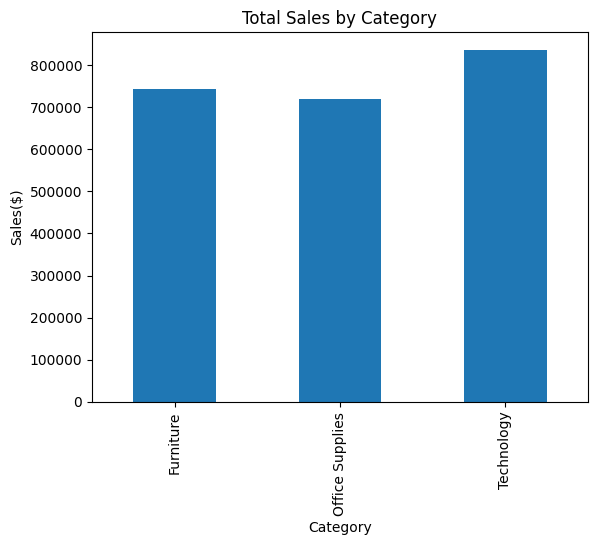

In [130]:
category_sales = data.groupby('Category')['Sales'].sum()
category_sales.plot(kind='bar')
plt.title('Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Sales($)')
plt.show()



In [131]:
# إزالة Outliers:
data = data[(data['Profit'] > data['Profit'].quantile(0.01)) & (data['Profit'] < data['Profit'].quantile(0.99))]



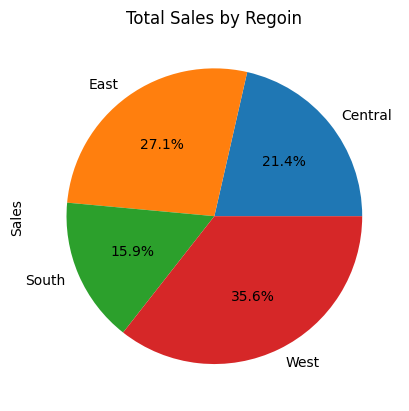

In [132]:
category_sales = data.groupby('Region')['Sales'].sum()
category_sales.plot(kind="pie" , autopct='%1.1f%%')
plt.title('Total Sales by Regoin' )
plt.show()

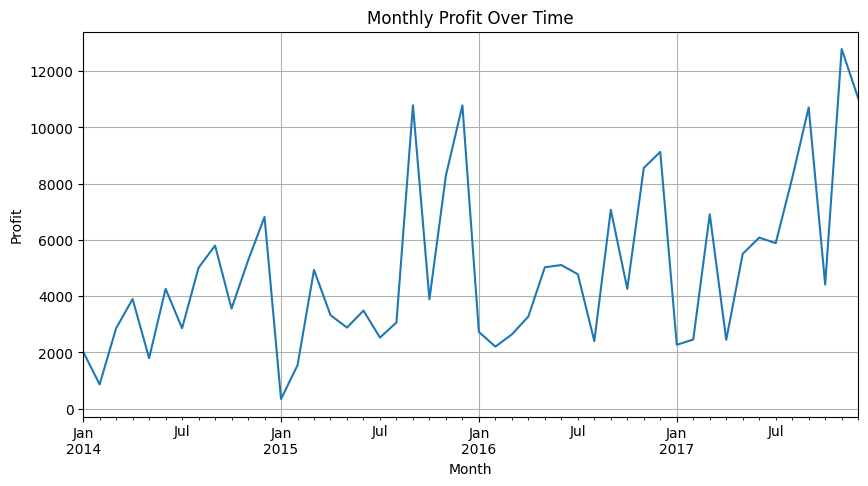

In [133]:
data['Order Date'] = pd.to_datetime(data['Order Date'])

monthly_profit = data.groupby(data['Order Date'].dt.to_period('M'))['Profit'].sum()
monthly_profit.index = monthly_profit.index.to_timestamp()

monthly_profit.plot(figsize=(10, 5))
plt.title('Monthly Profit Over Time')
plt.xlabel('Month')
plt.ylabel('Profit')
plt.grid(True)
plt.show()

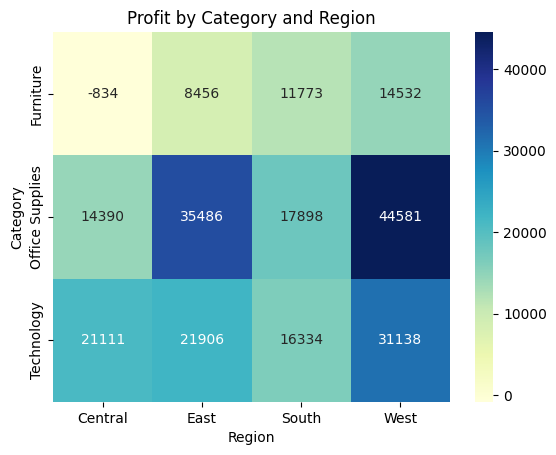

In [134]:
pivot_table = pd.pivot_table(data, values='Profit', index='Category', columns='Region', aggfunc='sum')

sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Profit by Category and Region')
plt.show()


In [135]:
#EDA
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9794 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9794 non-null   int64         
 1   Order ID       9794 non-null   object        
 2   Order Date     9794 non-null   datetime64[ns]
 3   Ship Date      9794 non-null   object        
 4   Ship Mode      9794 non-null   object        
 5   Customer ID    9794 non-null   object        
 6   Customer Name  9794 non-null   object        
 7   Segment        9794 non-null   object        
 8   Country        9794 non-null   object        
 9   City           9794 non-null   object        
 10  State          9794 non-null   object        
 11  Postal Code    9794 non-null   int64         
 12  Region         9794 non-null   object        
 13  Product ID     9794 non-null   object        
 14  Category       9794 non-null   object        
 15  Sub-Category   9794 non-nu

In [136]:
print(data.isnull().sum())

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


In [137]:
#Data Cleanning
data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [138]:
data=data.drop(['Row ID', 'Order ID', 'Order Date', 'Ship Date',
       'Customer ID', 'Customer Name',
       'Postal Code',  'Product ID' , 'Product Name'] , axis=1 )

In [139]:
data

,Ship Mode,Segment,Country,City,State,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,South,Furniture,Bookcases,261.960,2,0.0,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,South,Furniture,Chairs,731.940,3,0.0,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,West,Office Supplies,Labels,14.620,2,0.0,6.8714
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,South,Office Supplies,Storage,22.368,2,0.2,2.5164
5,Standard Class,Consumer,United States,Los Angeles,California,West,Furniture,Furnishings,48.860,7,0.0,14.1694
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,Second Class,Consumer,United States,Miami,Florida,South,Furniture,Furnishings,25.248,3,0.2,4.1028
9990,Standard Class,Consumer,United States,Costa Mesa,California,West,Furniture,Furnishings,91.960,2,0.0,15.6332
9991,Standard Class,Consumer,United States,Costa Mesa,California,West,Technology,Phones,258.576,2,0.2,19.3932
9992,Standard Class,Consumer,United States,Costa Mesa,California,West,Office Supplies,Paper,29.600,4,0.0,13.3200


In [140]:
data = pd.get_dummies(data, columns=["Category", "Sub-Category" , 'Country', 'Region', 'State', 'City', 'Ship Mode' ,  'Segment'], dtype=int)

data


,Sales,Quantity,Discount,Profit,Category_Furniture,Category_Office Supplies,Category_Technology,Sub-Category_Accessories,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables,Country_United States,Region_Central,Region_East,Region_South,Region_West,State_Alabama,State_Arizona,State_Arkansas,State_California,State_Colorado,State_Connecticut,State_Delaware,State_District of Columbia,State_Florida,State_Georgia,State_Idaho,...,City_Vancouver,City_Vineland,City_Virginia Beach,City_Visalia,City_Waco,City_Warner Robins,City_Warwick,City_Washington,City_Waterbury,City_Waterloo,City_Watertown,City_Waukesha,City_Wausau,City_Waynesboro,City_West Allis,City_West Jordan,City_West Palm Beach,City_Westfield,City_Westland,City_Westminster,City_Wheeling,City_Whittier,City_Wichita,City_Wilmington,City_Wilson,City_Woodbury,City_Woodland,City_Woodstock,City_Woonsocket,City_Yonkers,City_York,City_Yucaipa,City_Yuma,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office
0,261.960,2,0.0,41.9136,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,731.940,3,0.0,219.5820,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,14.620,2,0.0,6.8714,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,22.368,2,0.2,2.5164,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
5,48.860,7,0.0,14.1694,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,25.248,3,0.2,4.1028,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
9990,91.960,2,0.0,15.6332,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
9991,258.576,2,0.2,19.3932,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
9992,29.600,4,0.0,13.3200,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [141]:
y=data["Profit"]
x=data.drop(["Profit"] , axis=1)



In [142]:

scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train , x_test , y_train , y_test =model_selection.train_test_split(x ,y , test_size=0.2,random_state=42 )
print(x_train.shape , y_train.shape) , x_test , y_test


modeles={"RandomForestRegressor":RandomForestRegressor() , 
         "GradientBoostingRegressor":GradientBoostingRegressor() ,
         "LinearRegression" :LinearRegression(),
         "DecisionTreeRegressor":DecisionTreeRegressor(),
         "KNeighborsRegressor":KNeighborsRegressor(),
        "XGBRegressor":XGBRegressor()
         }

for name,x in modeles.items():
    
    x.fit(x_train,y_train)
    y_pred=x.predict(x_train)

    score=r2_score(y_train, y_pred)
    print(f"{name}  accuracy score is {score} ")
   
    



(7835, 615) (7835,)
RandomForestRegressor  accuracy score is 0.9775018801933145 
GradientBoostingRegressor  accuracy score is 0.8582383458576441 
LinearRegression  accuracy score is 0.5372453989797872 
DecisionTreeRegressor  accuracy score is 0.99990164611259 
KNeighborsRegressor  accuracy score is 0.5503947391350791 
XGBRegressor  accuracy score is 0.9477506117709218 


In [143]:
best_model=DecisionTreeRegressor()
best_model.fit(x_train,y_train)
y_pre=best_model.predict(x_test)
score1=r2_score(y_test , y_pre)
print(f"DecisionTreeRegressor accuracy score is {score1}")


DecisionTreeRegressor accuracy score is 0.76769075164538
